In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import re
import scanpy as sc
from scipy.sparse import csr_matrix

# Load data

In [18]:
filename =  '../data_out/batches/crispr_guide_capture-stim_5.h5ad'
# '../data_out/batches/crispr_guide_capture-nostim_1.h5ad'
# filename = '../data_out/batches/gene_expression-stim_5.h5ad'

In [19]:
adata = sc.read(
    filename,
    cache=True,
    gex_only=False,
    # make_unique=True
)

In [20]:
# Mas eficiente para entrenar
adata.X = csr_matrix(adata.X)

In [21]:
adata

AnnData object with n_obs × n_vars = 13260 × 146
    obs: 'condition', 'batch'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr'

In [22]:
adata.var.value_counts('CRISPr')

CRISPr
perturbed    146
Name: count, dtype: int64

# Doublets removal
(two or more cells are mistakenly captured together and sequenced as if they were a single cell)

In [23]:
import scvi

In [24]:
# 13260 × 36601 -> 13260 × 17607
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 13260 × 143
    obs: 'condition', 'batch'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'n_cells'

In [25]:
# The top 2000 genes that describe the data
# 13260 × 17607 -> 13260 × 2000
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat_v3')
adata

AnnData object with n_obs × n_vars = 13260 × 143
    obs: 'condition', 'batch'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [27]:
sc.pp.filter_cells(adata, min_genes=1)
adata

AnnData object with n_obs × n_vars = 13169 × 143
    obs: 'condition', 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [28]:
import torch
torch.set_float32_matmul_precision('medium')

In [29]:
# %% dl_num_workers
scvi.settings.dl_num_workers = 19
scvi.settings.batch_size = 512
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.to_device('cuda')
vae.train()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [30]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.461. Signaling Trainer to stop.


In [31]:
df = solo.predict()
df['prediction'] = solo.predict(soft=False)
df['dif'] = df.doublet - df.singlet
df

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction,dif
AAACCCAAGGGCGAAG-5,0.278014,0.721986,singlet,-0.443972
AAACCCACACAAATAG-5,0.621681,0.378319,doublet,0.243362
AAACCCACAGGGATAC-5,0.084335,0.915665,singlet,-0.831330
AAACCCAGTAAGACCG-5,0.392197,0.607803,singlet,-0.215607
AAACCCAGTCGTCGGT-5,0.831582,0.168418,doublet,0.663164
...,...,...,...,...
TTTGTTGTCAACCCGG-5,0.178921,0.821079,singlet,-0.642158
TTTGTTGTCCCTGGTT-5,0.630475,0.369525,doublet,0.260949
TTTGTTGTCCTACCGT-5,0.426497,0.573503,singlet,-0.147006
TTTGTTGTCGTTACCC-5,0.464854,0.535146,singlet,-0.070292


<Axes: >

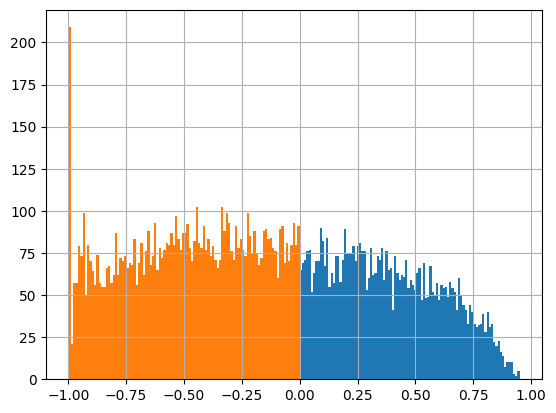

In [32]:
df[df['prediction']=='doublet']['dif'].hist(bins=100)
df[df['prediction']=='singlet']['dif'].hist(bins=100)

In [33]:
df.value_counts('prediction')

prediction
singlet    7764
doublet    5405
Name: count, dtype: int64

In [38]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 0.7)]
print(len(doublets)/len(df))
doublets

0.04996582884045865


,doublet,singlet,prediction,dif
AAACCCATCCGCGGAT-5,0.889838,0.110162,doublet,0.779676
AAACGCTGTCCTCCAT-5,0.862433,0.137567,doublet,0.724867
AAAGAACGTGGGTATG-5,0.911397,0.088603,doublet,0.822794
AAAGGATAGTGGAAGA-5,0.903720,0.096279,doublet,0.807441
AAAGGGCAGCATGCGA-5,0.856237,0.143763,doublet,0.712474
...,...,...,...,...
TTTAGTCGTGAATAAC-5,0.923576,0.076424,doublet,0.847152
TTTCAGTGTCGGAAAC-5,0.927810,0.072190,doublet,0.855619
TTTCAGTGTGATTCAC-5,0.937947,0.062053,doublet,0.875894
TTTCAGTTCTGTGCTC-5,0.893039,0.106961,doublet,0.786078


In [69]:
adata = sc.read(
    filename,
    cache=True,
    gex_only=False,
    # make_unique=True
)

In [70]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata

AnnData object with n_obs × n_vars = 13260 × 146
    obs: 'condition', 'batch', 'doublet'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr'

In [71]:
adata = adata[~adata.obs['doublet']]
adata

View of AnnData object with n_obs × n_vars = 12602 × 146
    obs: 'condition', 'batch', 'doublet'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr'

# Preprocessing

In [72]:
# Mitocondrial, 13
adata.var['mt'] = adata.var.index.str.startswith('MT-')
adata.var.value_counts('mt')


/tmp/ipykernel_272026/2836639413.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


mt
False    146
Name: count, dtype: int64

In [73]:
# Ribosomal Genes
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes


,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [74]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var.value_counts('ribo')

ribo
False    146
Name: count, dtype: int64

In [75]:
adata.var

,gene_ids,feature_types,Gene Clean Name,CRISPr,mt,ribo
ABCB10-1,ABCB10-1,CRISPR Guide Capture,ABCB10,perturbed,False,False
ABCB10-2,ABCB10-2,CRISPR Guide Capture,ABCB10,perturbed,False,False
AKAP12-1,AKAP12-1,CRISPR Guide Capture,AKAP12,perturbed,False,False
AKAP12-2,AKAP12-2,CRISPR Guide Capture,AKAP12,perturbed,False,False
ALX4-1,ALX4-1,CRISPR Guide Capture,ALX4,perturbed,False,False
...,...,...,...,...,...,...
TRIM21-2,TRIM21-2,CRISPR Guide Capture,TRIM21,perturbed,False,False
VAV1-1,VAV1-1,CRISPR Guide Capture,VAV1,perturbed,False,False
VAV1-2,VAV1-2,CRISPR Guide Capture,VAV1,perturbed,False,False
WT1-1,WT1-1,CRISPR Guide Capture,WT1,perturbed,False,False


In [76]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [77]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,Gene Clean Name,CRISPr,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
TCF7-1,TCF7-1,CRISPR Guide Capture,TCF7,perturbed,False,False,0,0.000000,100.000000,0.0
IRX4-1,IRX4-1,CRISPR Guide Capture,IRX4,perturbed,False,False,1,0.005158,99.992065,65.0
DEF6-2,DEF6-2,CRISPR Guide Capture,DEF6,perturbed,False,False,5,0.063482,99.960324,800.0
IRX4-2,IRX4-2,CRISPR Guide Capture,IRX4,perturbed,False,False,8,0.136566,99.936518,1721.0
HELZ2-2,HELZ2-2,CRISPR Guide Capture,HELZ2,perturbed,False,False,14,0.113395,99.888907,1429.0
...,...,...,...,...,...,...,...,...,...,...
TAGAP-1,TAGAP-1,CRISPR Guide Capture,TAGAP,perturbed,False,False,1246,3.893271,90.112681,49063.0
LAT2-2,LAT2-2,CRISPR Guide Capture,LAT2,perturbed,False,False,1269,7.127837,89.930170,89825.0
EMP1-2,EMP1-2,CRISPR Guide Capture,EMP1,perturbed,False,False,1401,5.764799,88.882717,72648.0
CBY1-2,CBY1-2,CRISPR Guide Capture,CBY1,perturbed,False,False,1526,4.009681,87.890811,50530.0


In [78]:
sc.pp.filter_genes(adata, min_cells=3)
adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,Gene Clean Name,CRISPr,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
DEF6-2,DEF6-2,CRISPR Guide Capture,DEF6,perturbed,False,False,5,0.063482,99.960324,800.0,5
IRX4-2,IRX4-2,CRISPR Guide Capture,IRX4,perturbed,False,False,8,0.136566,99.936518,1721.0,8
HELZ2-2,HELZ2-2,CRISPR Guide Capture,HELZ2,perturbed,False,False,14,0.113395,99.888907,1429.0,14
PAPOLG-1,PAPOLG-1,CRISPR Guide Capture,PAPOLG,perturbed,False,False,20,0.007380,99.841295,93.0,20
PRDM1-2,PRDM1-2,CRISPR Guide Capture,PRDM1,perturbed,False,False,24,0.125218,99.809554,1578.0,24
...,...,...,...,...,...,...,...,...,...,...,...
TAGAP-1,TAGAP-1,CRISPR Guide Capture,TAGAP,perturbed,False,False,1246,3.893271,90.112681,49063.0,1246
LAT2-2,LAT2-2,CRISPR Guide Capture,LAT2,perturbed,False,False,1269,7.127837,89.930170,89825.0,1269
EMP1-2,EMP1-2,CRISPR Guide Capture,EMP1,perturbed,False,False,1401,5.764799,88.882717,72648.0,1401
CBY1-2,CBY1-2,CRISPR Guide Capture,CBY1,perturbed,False,False,1526,4.009681,87.890811,50530.0,1526


In [79]:
adata.obs.sort_values('n_genes_by_counts')

,condition,batch,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
AACCTTTAGTAGCAAT-5,Stim,5,False,0,0.0,0.0,NaN,0.0,NaN
GCATTAGCAAGGGCAT-5,Stim,5,False,0,0.0,0.0,NaN,0.0,NaN
TCACGCTGTCAGGTAG-5,Stim,5,False,0,0.0,0.0,NaN,0.0,NaN
ACGGTCGTCGTTCCTG-5,Stim,5,False,0,0.0,0.0,NaN,0.0,NaN
TGTTCCGCACTTTAGG-5,Stim,5,False,0,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...
GGGAGATGTGATAGAT-5,Stim,5,False,15,2311.0,0.0,0.0,0.0,0.0
TGGGCGTCAAACCACT-5,Stim,5,False,15,1930.0,0.0,0.0,0.0,0.0
CTGCAGGCAAGAGTTA-5,Stim,5,False,16,3250.0,0.0,0.0,0.0,0.0
TTCTAGTCATAGACTC-5,Stim,5,False,17,1156.0,0.0,0.0,0.0,0.0


In [80]:
sc.pp.filter_cells(adata, min_genes=1)
adata.obs.sort_values('n_genes_by_counts')

,condition,batch,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
GACCGTGTCCATATGG-5,Stim,5,False,1,1.0,0.0,0.0,0.0,0.0,1
GACCTTCGTTTGAACC-5,Stim,5,False,1,1.0,0.0,0.0,0.0,0.0,1
GACGCTGCAAGACGGT-5,Stim,5,False,1,50.0,0.0,0.0,0.0,0.0,1
GACGCTGCAGCCTATA-5,Stim,5,False,1,1.0,0.0,0.0,0.0,0.0,1
GACGTTATCGTCGACG-5,Stim,5,False,1,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
TGGGCGTCAAACCACT-5,Stim,5,False,15,1930.0,0.0,0.0,0.0,0.0,15
CAGTTAGCAATACGAA-5,Stim,5,False,15,2240.0,0.0,0.0,0.0,0.0,15
CTGCAGGCAAGAGTTA-5,Stim,5,False,16,3250.0,0.0,0.0,0.0,0.0,16
TTCTAGTCATAGACTC-5,Stim,5,False,17,1156.0,0.0,0.0,0.0,0.0,17


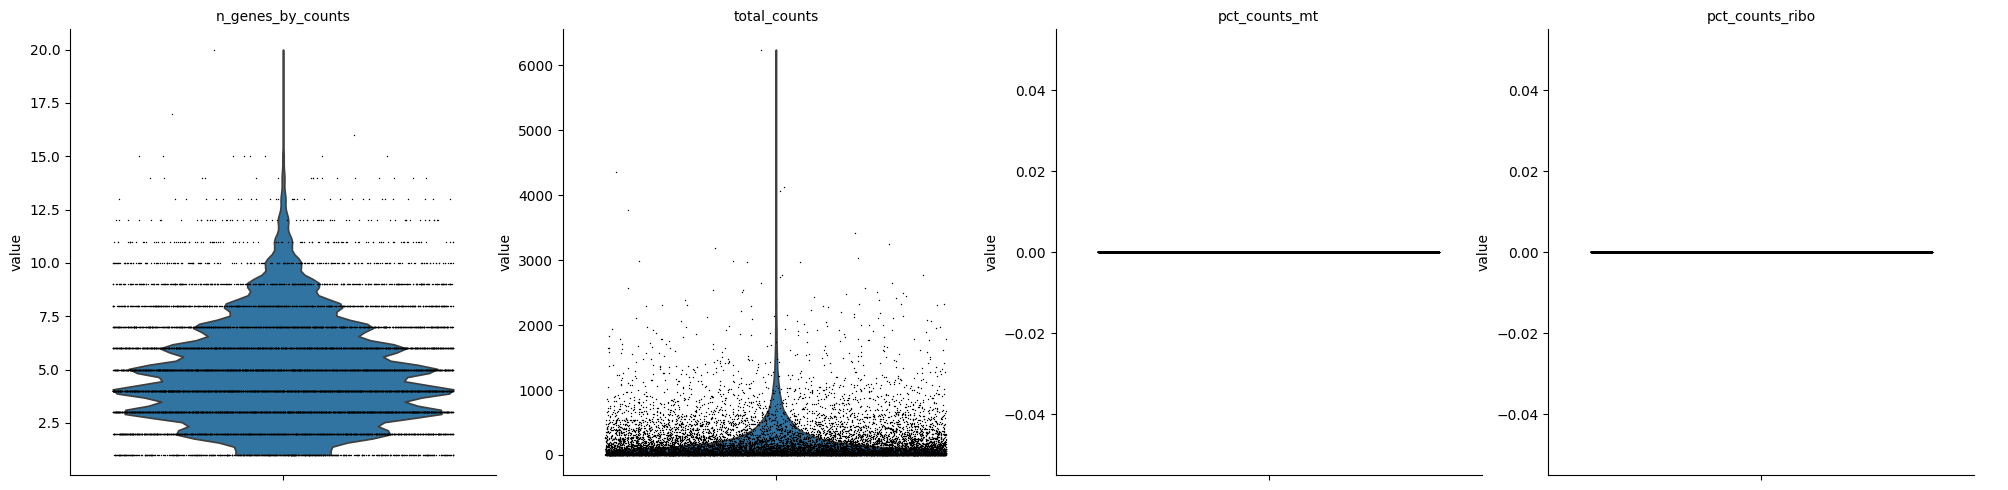

In [81]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [82]:
import numpy as np
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_lim

10.0

In [83]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata

View of AnnData object with n_obs × n_vars = 12046 × 144
    obs: 'condition', 'batch', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [68]:
upper_lim = np.quantile(adata.obs.pct_counts_mt.values, .98)
print(upper_lim)
adata = adata[adata.obs.pct_counts_mt < upper_lim]
adata

IndexError: index -1 is out of bounds for axis 0 with size 0

In [67]:
upper_lim = np.quantile(adata.obs.pct_counts_ribo.values, .98)
print(upper_lim)
adata = adata[adata.obs.pct_counts_ribo < upper_lim]
adata

20.94023036956787


View of AnnData object with n_obs × n_vars = 10805 × 20271
    obs: 'condition', 'batch', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

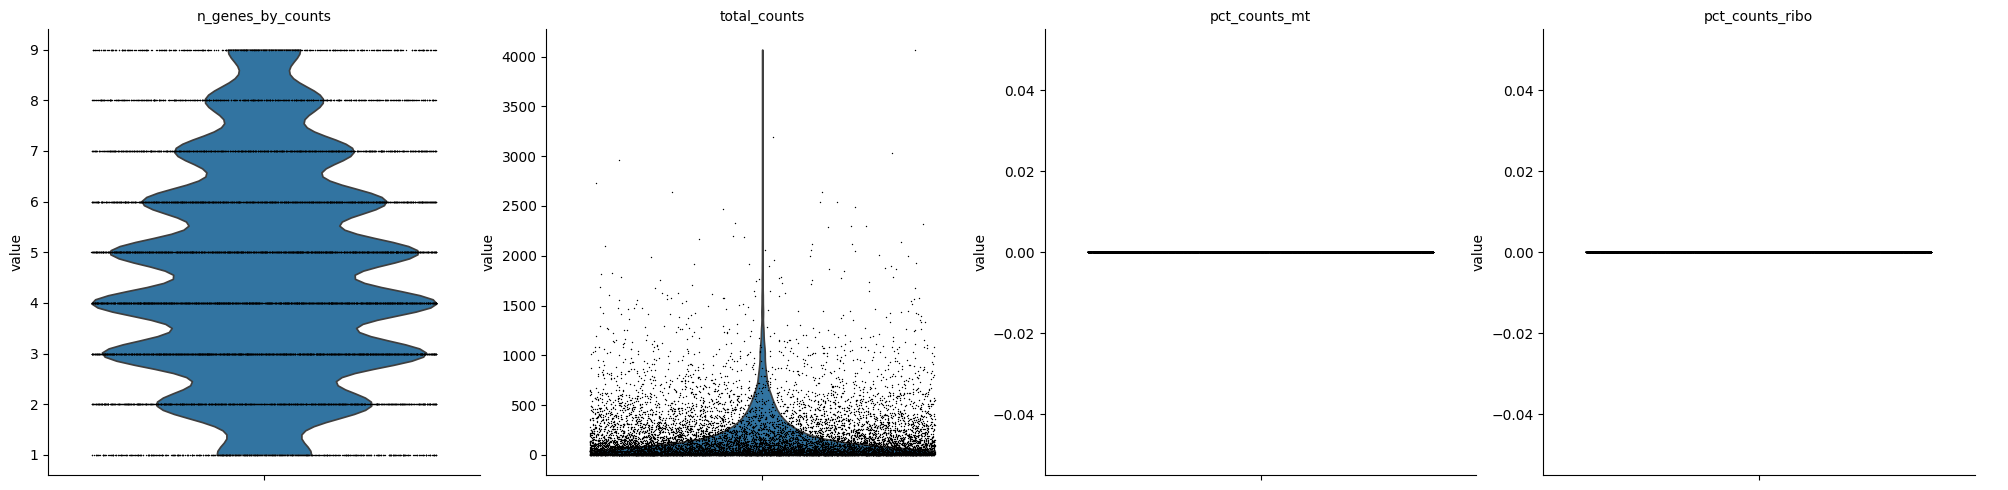

In [84]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

# Normalization

In [85]:
adata.X.sum(axis = 1)

matrix([[ 17.],
        [595.],
        [  8.],
        ...,
        [ 27.],
        [ 46.],
        [ 60.]], dtype=float32)

In [86]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [87]:
adata.X.sum(axis = 1)

matrix([[10000.   ],
        [10000.   ],
        [10000.   ],
        ...,
        [ 9999.999],
        [10000.   ],
        [10000.   ]], dtype=float32)

In [88]:
sc.pp.log1p(adata) #change to log counts
adata.X.sum(axis = 1)

matrix([[21.842943],
        [28.713085],
        [16.208622],
        ...,
        [26.84427 ],
        [14.574751],
        [19.420498]], dtype=float32)

In [89]:
adata.raw = adata

In [90]:
adata

AnnData object with n_obs × n_vars = 12046 × 144
    obs: 'condition', 'batch', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

# Clustering

In [91]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [92]:
adata.var

,gene_ids,feature_types,Gene Clean Name,CRISPr,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
ABCB10-1,ABCB10-1,CRISPR Guide Capture,ABCB10,perturbed,False,False,109,0.723377,99.135058,9116.0,109,True,3.371722,9.016522,1.929588
ABCB10-2,ABCB10-2,CRISPR Guide Capture,ABCB10,perturbed,False,False,86,0.125298,99.317569,1579.0,86,True,3.337936,8.898691,0.079169
AKAP12-1,AKAP12-1,CRISPR Guide Capture,AKAP12,perturbed,False,False,151,0.528408,98.801777,6659.0,151,True,3.636349,8.938706,0.514771
AKAP12-2,AKAP12-2,CRISPR Guide Capture,AKAP12,perturbed,False,False,43,0.094429,99.658784,1190.0,43,True,2.784081,8.928532,-0.707107
ALX4-1,ALX4-1,CRISPR Guide Capture,ALX4,perturbed,False,False,306,2.098794,97.571814,26449.0,306,True,4.319795,9.023642,1.666366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRIM21-2,TRIM21-2,CRISPR Guide Capture,TRIM21,perturbed,False,False,1050,2.581257,91.667989,32529.0,1050,True,4.835586,8.796522,-0.632632
VAV1-1,VAV1-1,CRISPR Guide Capture,VAV1,perturbed,False,False,140,0.301381,98.889065,3798.0,140,True,3.500626,8.896704,0.075195
VAV1-2,VAV1-2,CRISPR Guide Capture,VAV1,perturbed,False,False,471,1.227583,96.262498,15470.0,471,True,4.623975,8.937044,0.568358
WT1-1,WT1-1,CRISPR Guide Capture,WT1,perturbed,False,False,1049,3.649897,91.675924,45996.0,1049,True,4.949167,8.833109,0.127017


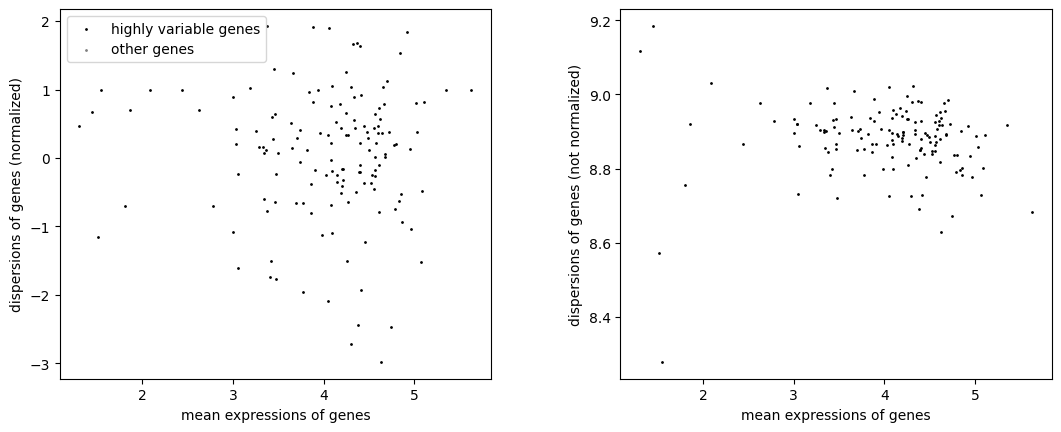

In [93]:
sc.pl.highly_variable_genes(adata)

In [94]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 12046 × 144
    obs: 'condition', 'batch', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'gene_ids', 'feature_types', 'Gene Clean Name', 'CRISPr', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [95]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [96]:
sc.pp.scale(adata, max_value=10)

In [97]:
sc.tl.pca(adata, svd_solver='arpack')

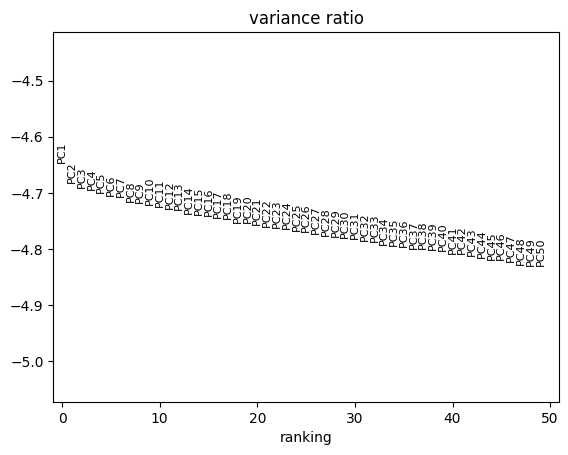

In [98]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [99]:
sc.pp.neighbors(adata, n_pcs = 10)

In [100]:
sc.tl.umap(adata)

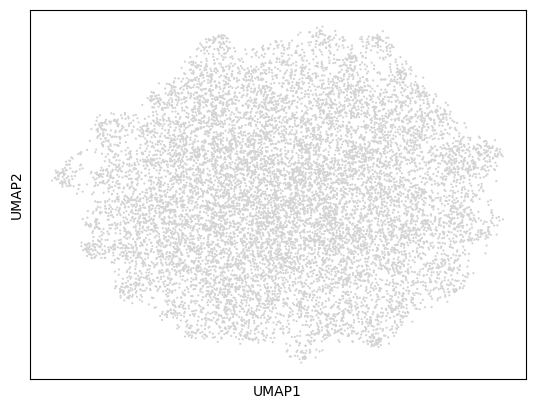

In [101]:
sc.pl.umap(adata)

In [102]:
sc.tl.leiden(adata, resolution = 0.5)

/tmp/ipykernel_272026/3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


In [103]:
adata.obs

,condition,batch,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
AAACCCAAGGGCGAAG-5,Stim,5,False,3,17.0,0.0,0.0,0.0,0.0,3,0
AAACCCACACAAATAG-5,Stim,5,False,7,595.0,0.0,0.0,0.0,0.0,7,1
AAACCCACAGGGATAC-5,Stim,5,False,2,8.0,0.0,0.0,0.0,0.0,2,7
AAACCCAGTAAGACCG-5,Stim,5,False,4,28.0,0.0,0.0,0.0,0.0,4,2
AAACCCAGTCGTCGGT-5,Stim,5,False,8,1202.0,0.0,0.0,0.0,0.0,8,1
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAACCCGG-5,Stim,5,False,3,17.0,0.0,0.0,0.0,0.0,3,10
TTTGTTGTCCCTGGTT-5,Stim,5,False,6,35.0,0.0,0.0,0.0,0.0,6,3
TTTGTTGTCCTACCGT-5,Stim,5,False,4,27.0,0.0,0.0,0.0,0.0,4,5
TTTGTTGTCGTTACCC-5,Stim,5,False,2,46.0,0.0,0.0,0.0,0.0,2,6


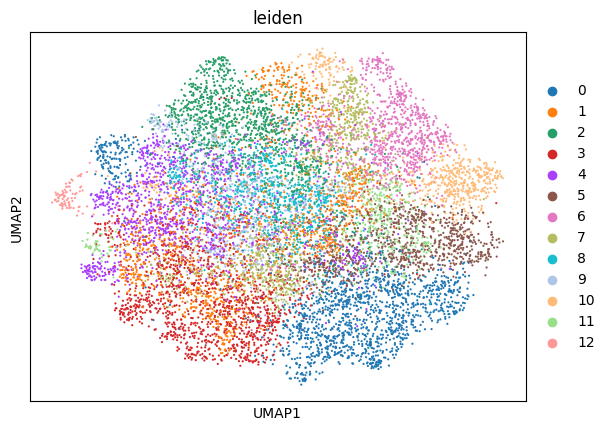

In [104]:
sc.pl.umap(adata, color=['leiden'])